# Predicting-Engineering-Graduate-Salaries-using-Machine-Learning

End-to-end workflow that explores factors influencing engineering graduate salaries and builds baseline predictive models (Linear Regression, Ridge, Lasso).


## 📌 Project Overview

This notebook explores how different academic, skill-based, and demographic factors affect **engineering graduates’ starting salaries**.  
The workflow covers:

- **Exploratory Data Analysis (EDA):** Understanding distributions, trends, and correlations.  
- **Data Preparation:** Cleaning, scaling numeric features, and encoding categoricals.  
- **Modeling:** Training baseline **Linear Regression**, applying **feature selection**, and tuning **Ridge & Lasso** models.  
- **Evaluation:** Comparing models using RMSE on validation and test sets.

The goal is to **identify the most influential features** and build a reliable baseline predictive model for graduate salaries.


In [1]:
# Setup & Imports

import os
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error

# Plot aesthetics
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (9, 4)
plt.rcParams["axes.titlesize"] = 13
plt.rcParams["axes.labelsize"] = 11
np.random.seed(42)

print("Versions → pandas:", pd.__version__, "| numpy:", np.__version__)

Versions → pandas: 2.3.1 | numpy: 2.2.6


In [2]:
# Data Loading

# Common candidate filenames (add more variants if you ever rename)
CANDIDATE_FILES = [
    "Engineering_graduate_salary.csv",
    "Engineering_graduate_salary_Instructions.csv",
]

# Candidate locations relative to *where the notebook is executed*
CANDIDATE_PATHS = []
for fname in CANDIDATE_FILES:
    CANDIDATE_PATHS += [
        Path("Data") / fname,          # running from repo root
        Path("../Data") / fname,       # running from Notebooks/
        Path("./Data") / fname,        # some IDEs normalize to ./Data
    ]

CSV_PATH = None
for p in CANDIDATE_PATHS:
    if p.exists():
        CSV_PATH = p
        break

if CSV_PATH is None:
    tried = "\n  - " + "\n  - ".join(str(p) for p in CANDIDATE_PATHS)
    raise FileNotFoundError(
        "❌ Could not find the dataset in expected locations.\n"
        "Place the CSV under the repo's Data/ folder. Tried:" + tried
    )

print(f"✅ Loading dataset from: {CSV_PATH}")
df = pd.read_csv(CSV_PATH)

✅ Loading dataset from: ../Data/Engineering_graduate_salary_Instructions.csv


## Quick sanity checks

In [3]:
df.head()

,ID,Gender,DOB,10percentage,10board,12graduation,12percentage,12board,CollegeID,CollegeTier,...,MechanicalEngg,ElectricalEngg,TelecomEngg,CivilEngg,conscientiousness,agreeableness,extraversion,nueroticism,openess_to_experience,Salary
0,604399,f,1990-10-22,87.80,cbse,2009,84.00,cbse,6920,1,...,-1,-1,-1,-1,-0.1590,0.3789,1.2396,0.14590,0.2889,445000
1,988334,m,1990-05-15,57.00,cbse,2010,64.50,cbse,6624,2,...,-1,-1,-1,-1,1.1336,0.0459,1.2396,0.52620,-0.2859,110000
2,301647,m,1989-08-21,77.33,"maharashtra state board,pune",2007,85.17,amravati divisional board,9084,2,...,-1,-1,260,-1,0.5100,-0.1232,1.5428,-0.29020,-0.2875,255000
3,582313,m,1991-05-04,84.30,cbse,2009,86.00,cbse,8195,1,...,-1,-1,-1,-1,-0.4463,0.2124,0.3174,0.27270,0.4805,420000
4,339001,f,1990-10-30,82.00,cbse,2008,75.00,cbse,4889,2,...,-1,-1,-1,-1,-1.4992,-0.7473,-1.0697,0.06223,0.1864,200000


In [4]:
print("Shape (rows, cols):", df.shape)

Shape (rows, cols): (2998, 34)


In [5]:
df.describe

<bound method NDFrame.describe of           ID Gender         DOB  10percentage                       10board  \
0     604399      f  1990-10-22         87.80                          cbse   
1     988334      m  1990-05-15         57.00                          cbse   
2     301647      m  1989-08-21         77.33  maharashtra state board,pune   
3     582313      m  1991-05-04         84.30                          cbse   
4     339001      f  1990-10-30         82.00                          cbse   
...      ...    ...         ...           ...                           ...   
2993  103174      f  1989-04-17         75.00                             0   
2994  352811      f  1991-07-22         84.00                   state board   
2995  287070      m  1988-11-24         91.40                         bsemp   
2996  317336      m  1988-08-25         88.64     karnataka education board   
2997  993701      m  1992-05-27         77.00                   state board   

      12graduatio

In [6]:
display(df.describe(include='all').T)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ID,2998.0,NaN,NaN,NaN,664892.583389,364895.076716,11244.0,333464.75,639694.5,995177.0,1297877.0
Gender,2998,2,m,2282,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DOB,2998,1633,1991-07-03,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10percentage,2998.0,NaN,NaN,NaN,77.666264,10.002785,43.0,71.14,78.965,85.6,97.76
10board,2998,221,cbse,1026,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12graduation,2998.0,NaN,NaN,NaN,2008.08072,1.631814,1998.0,2007.0,2008.0,2009.0,2012.0
12percentage,2998.0,NaN,NaN,NaN,74.341061,11.120299,40.0,66.0,74.0,82.6,98.7
12board,2998,277,cbse,1039,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CollegeID,2998.0,NaN,NaN,NaN,5210.210807,4776.609877,2.0,526.25,4027.5,8822.25,18409.0
CollegeTier,2998.0,NaN,NaN,NaN,1.924616,0.264053,1.0,2.0,2.0,2.0,2.0


In [7]:
print("Nulls per column:\n", df.isnull().sum())

Nulls per column:
 ID                       0
Gender                   0
DOB                      0
10percentage             0
10board                  0
12graduation             0
12percentage             0
12board                  0
CollegeID                0
CollegeTier              0
Degree                   0
Specialization           0
collegeGPA               0
CollegeCityID            0
CollegeCityTier          0
CollegeState             0
GraduationYear           0
English                  0
Logical                  0
Quant                    0
Domain                   0
ComputerProgramming      0
ElectronicsAndSemicon    0
ComputerScience          0
MechanicalEngg           0
ElectricalEngg           0
TelecomEngg              0
CivilEngg                0
conscientiousness        0
agreeableness            0
extraversion             0
nueroticism              0
openess_to_experience    0
Salary                   0
dtype: int64


## Exploratory Data Analysis (EDA)
We’ll visualize core distributions and relationships used later for feature prep and modeling.


/var/folders/tk/2jxvklsx3pv5sgh5rjj6x7zm0000gn/T/ipykernel_36789/956184603.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x='Gender', palette="Set2")


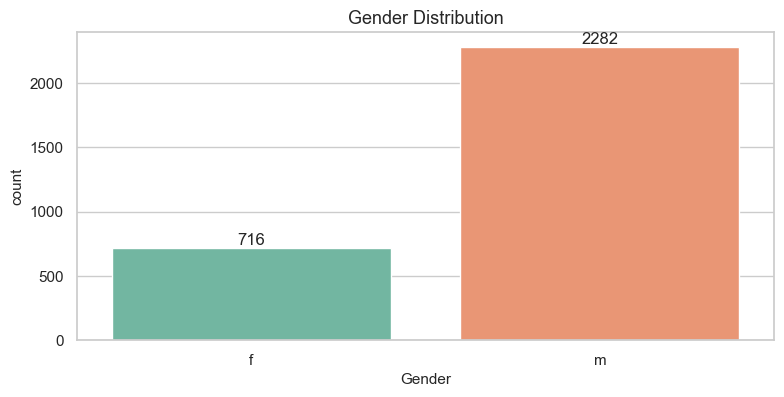

In [8]:
# Gender distribution
ax = sns.countplot(data=df, x='Gender', palette="Set2")
ax.set_title("Gender Distribution")

# Add numbers on top of each bar
for p in ax.patches:
    ax.annotate(
        f'{int(p.get_height())}', 
        (p.get_x() + p.get_width() / 2., p.get_height()), 
        ha='center', va='bottom'
    )

plt.show()

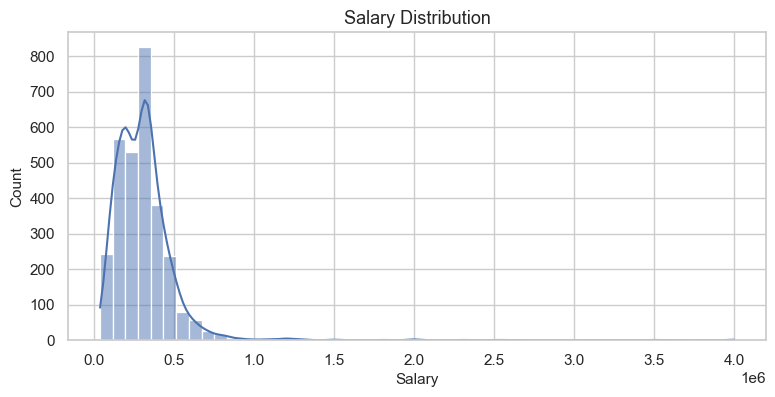

In [9]:
# Salary distribution
ax = sns.histplot(df['Salary'], bins=50, kde=True)
ax.set_title("Salary Distribution")
ax.set_xlabel("Salary"); ax.set_ylabel("Count")
plt.show()

/var/folders/tk/2jxvklsx3pv5sgh5rjj6x7zm0000gn/T/ipykernel_36789/1264720043.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x='CollegeTier', palette="Set2", edgecolor="black")


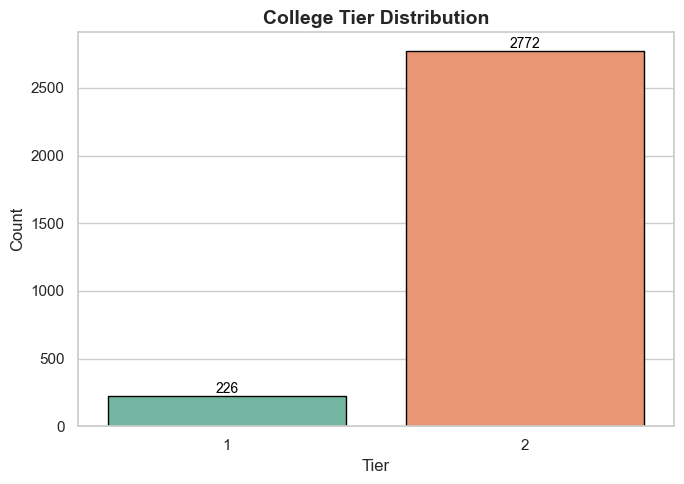

In [10]:
# College Tier distribution
plt.figure(figsize=(7,5))
ax = sns.countplot(data=df, x='CollegeTier', palette="Set2", edgecolor="black")

# Title & Labels
ax.set_title("College Tier Distribution", fontsize=14, fontweight="bold")
ax.set_xlabel("Tier", fontsize=12)
ax.set_ylabel("Count", fontsize=12)

# Add counts on top of bars
for p in ax.patches:
    count = int(p.get_height())
    ax.text(p.get_x() + p.get_width()/2, 
            count + 0.5, 
            f"{count}", 
            ha='center', va='bottom', fontsize=10, color="black")

plt.tight_layout()
plt.show()

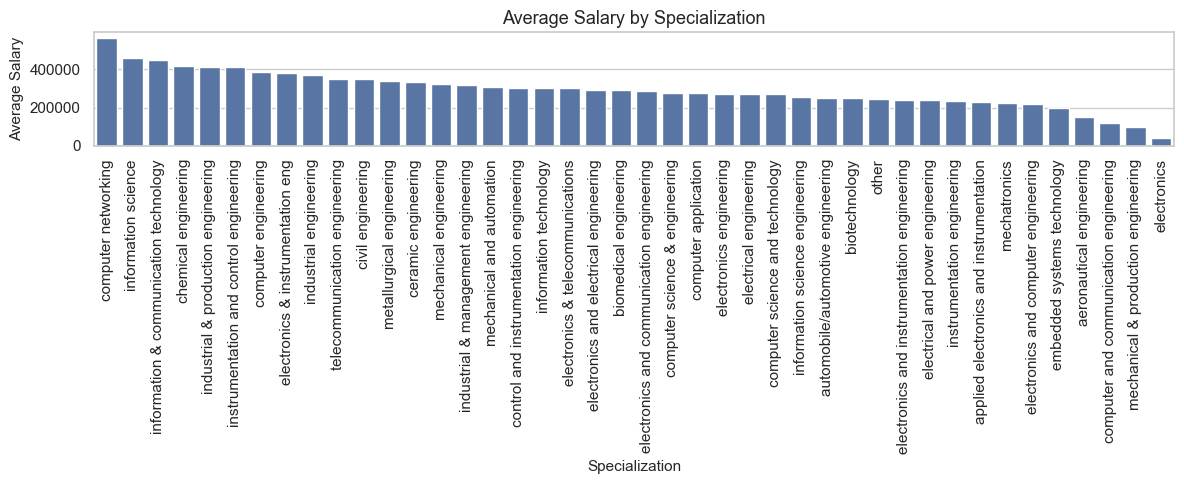

In [11]:
# Average Salary by Specialization
avg_salary_by_spec = (
    df.groupby('Specialization')['Salary']
      .mean()
      .sort_values(ascending=False)
)

plt.figure(figsize=(12, 5))
ax = sns.barplot(x=avg_salary_by_spec.index, y=avg_salary_by_spec.values)
ax.set_title("Average Salary by Specialization")
ax.set_xlabel("Specialization"); ax.set_ylabel("Average Salary")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


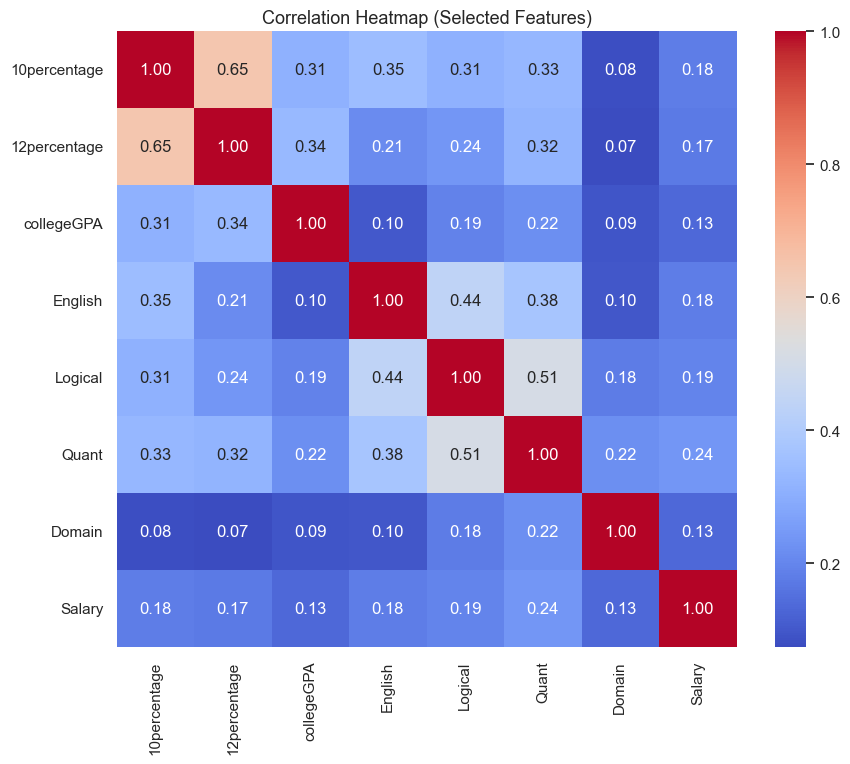

In [12]:
# Correlation heatmap for key features
selected_corr_cols = [
    '10percentage', '12percentage', 'collegeGPA',
    'English', 'Logical', 'Quant', 'Domain', 'Salary'
]
corr_df = df[selected_corr_cols].copy()

plt.figure(figsize=(10, 8))
ax = sns.heatmap(corr_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
ax.set_title("Correlation Heatmap (Selected Features)")
plt.show()


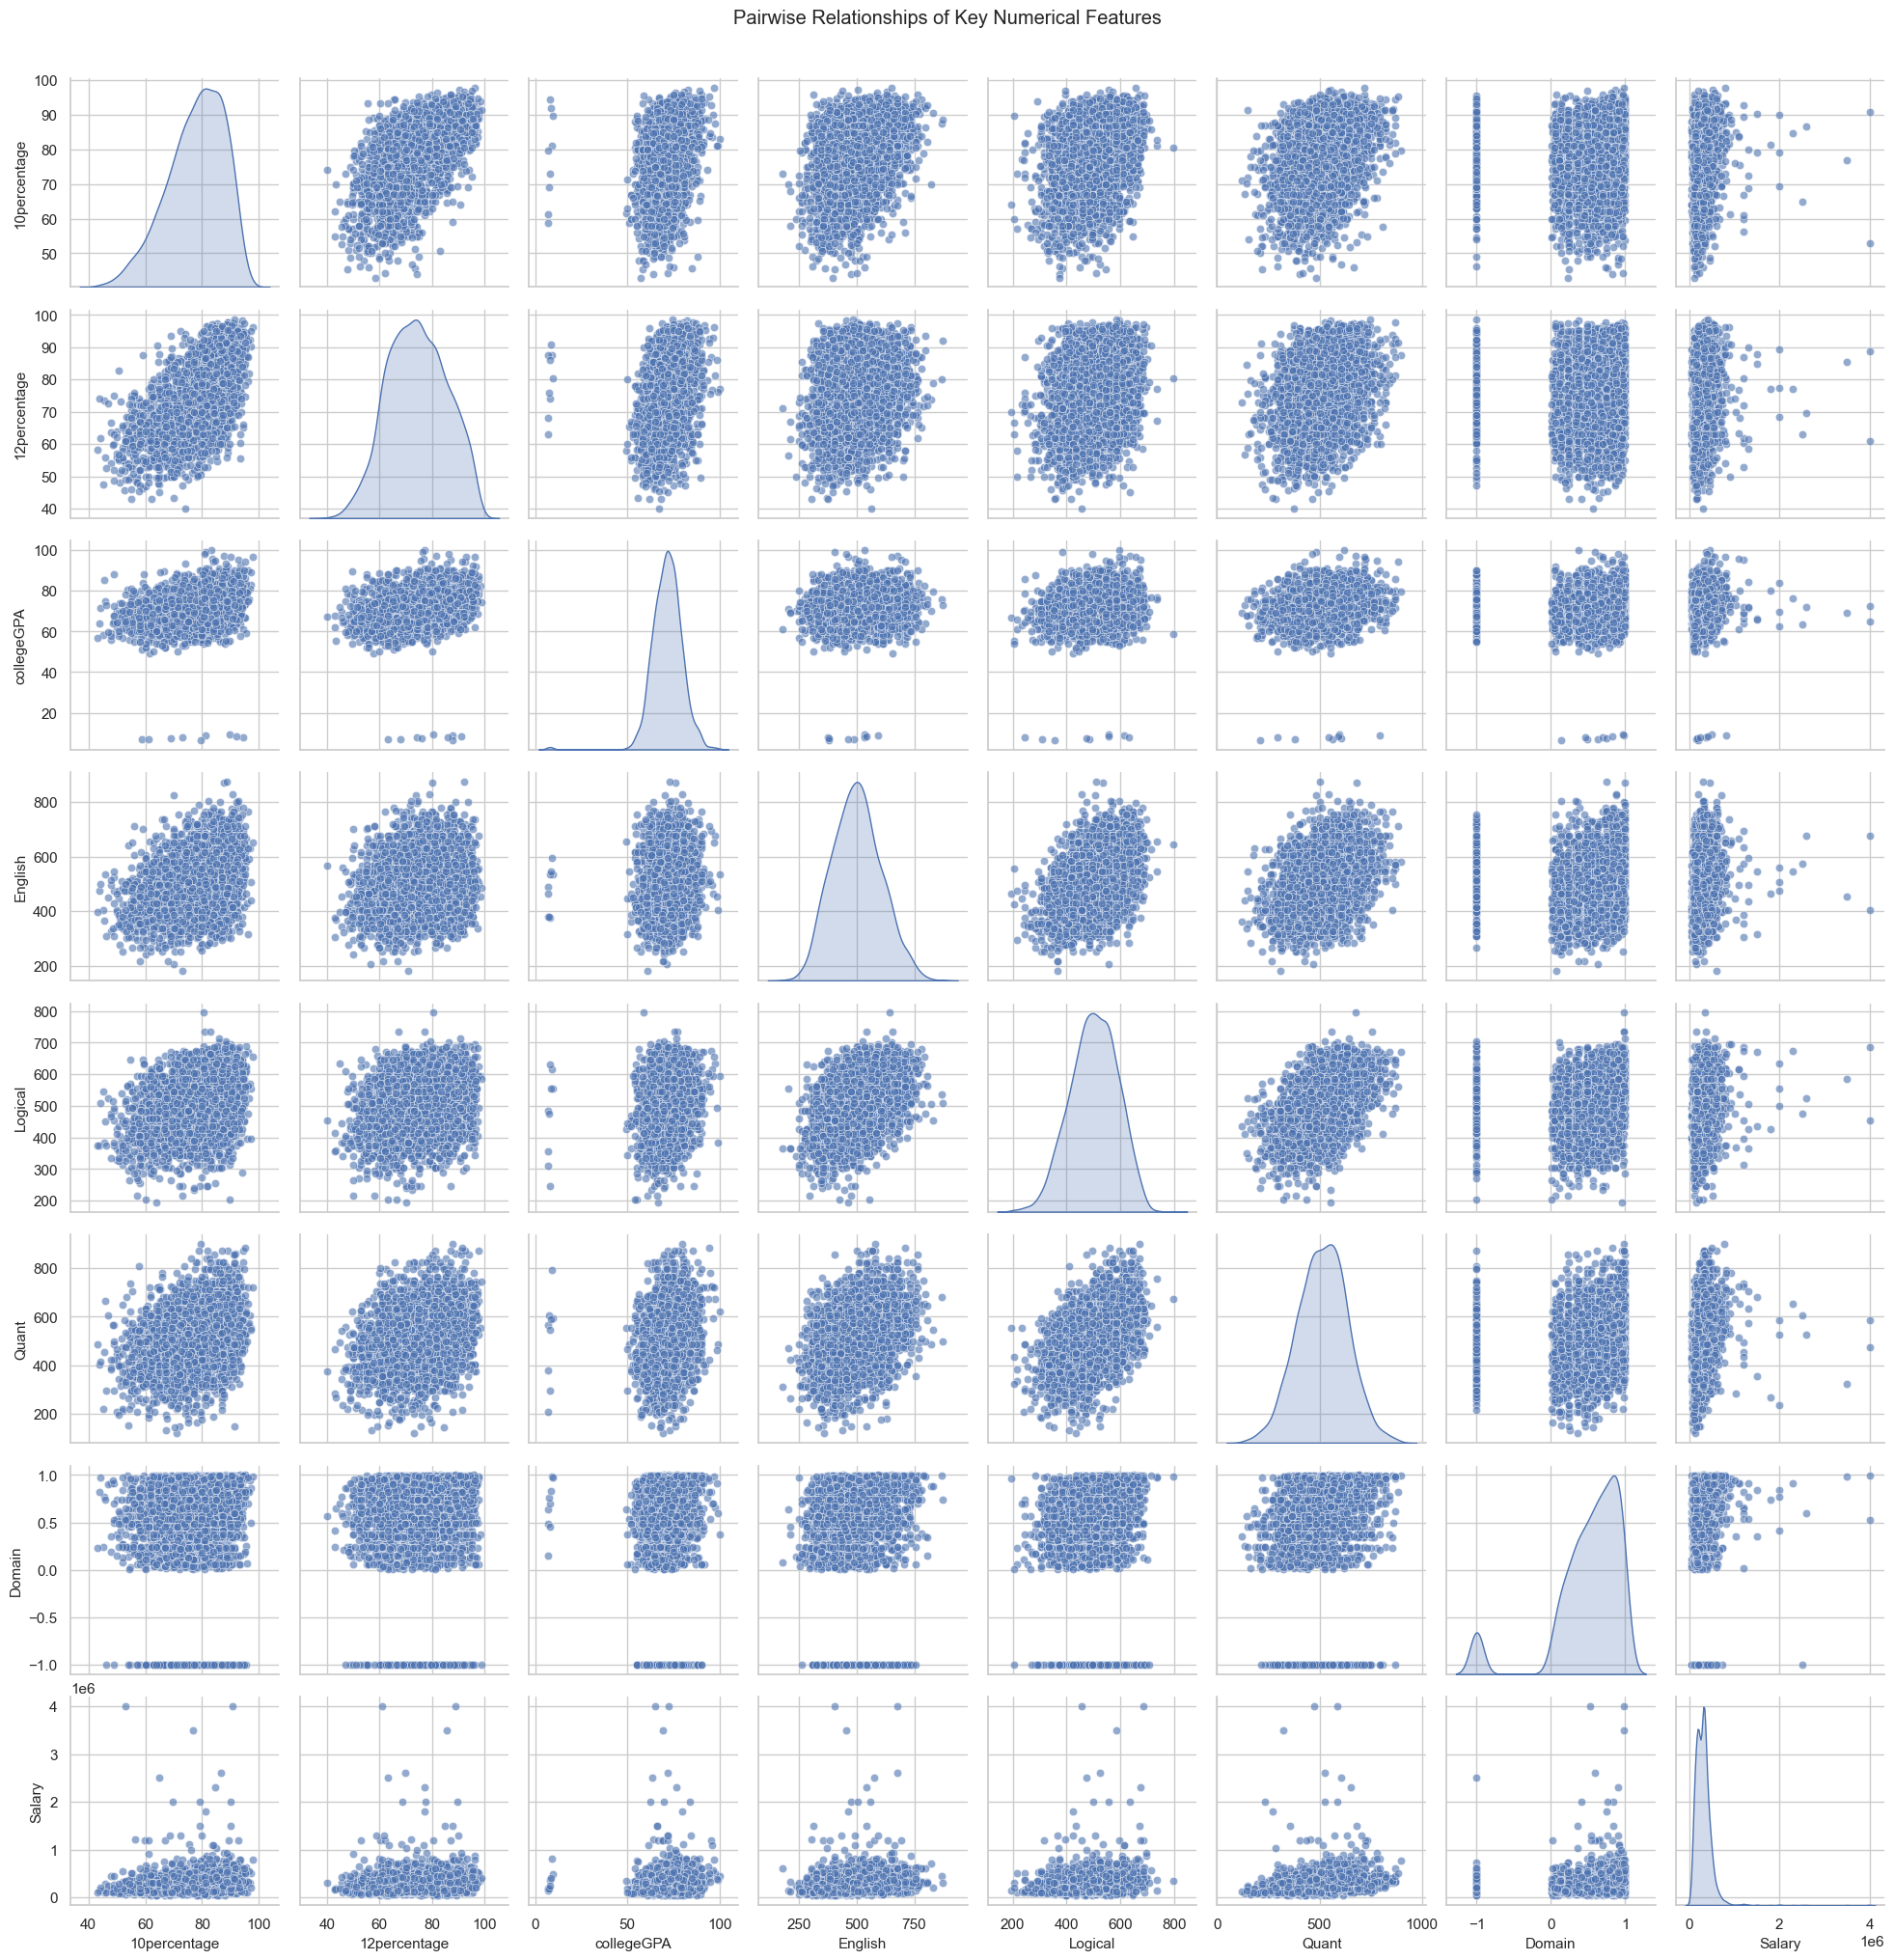

In [13]:
# Pairwise relationships across selected numerical features
selected_features = [
    '10percentage', '12percentage', 'collegeGPA',
    'English', 'Logical', 'Quant', 'Domain', 'Salary'
]
sns.pairplot(df[selected_features], diag_kind='kde', plot_kws={'alpha': 0.6})
plt.suptitle("Pairwise Relationships of Key Numerical Features", y=1.02)
plt.show()

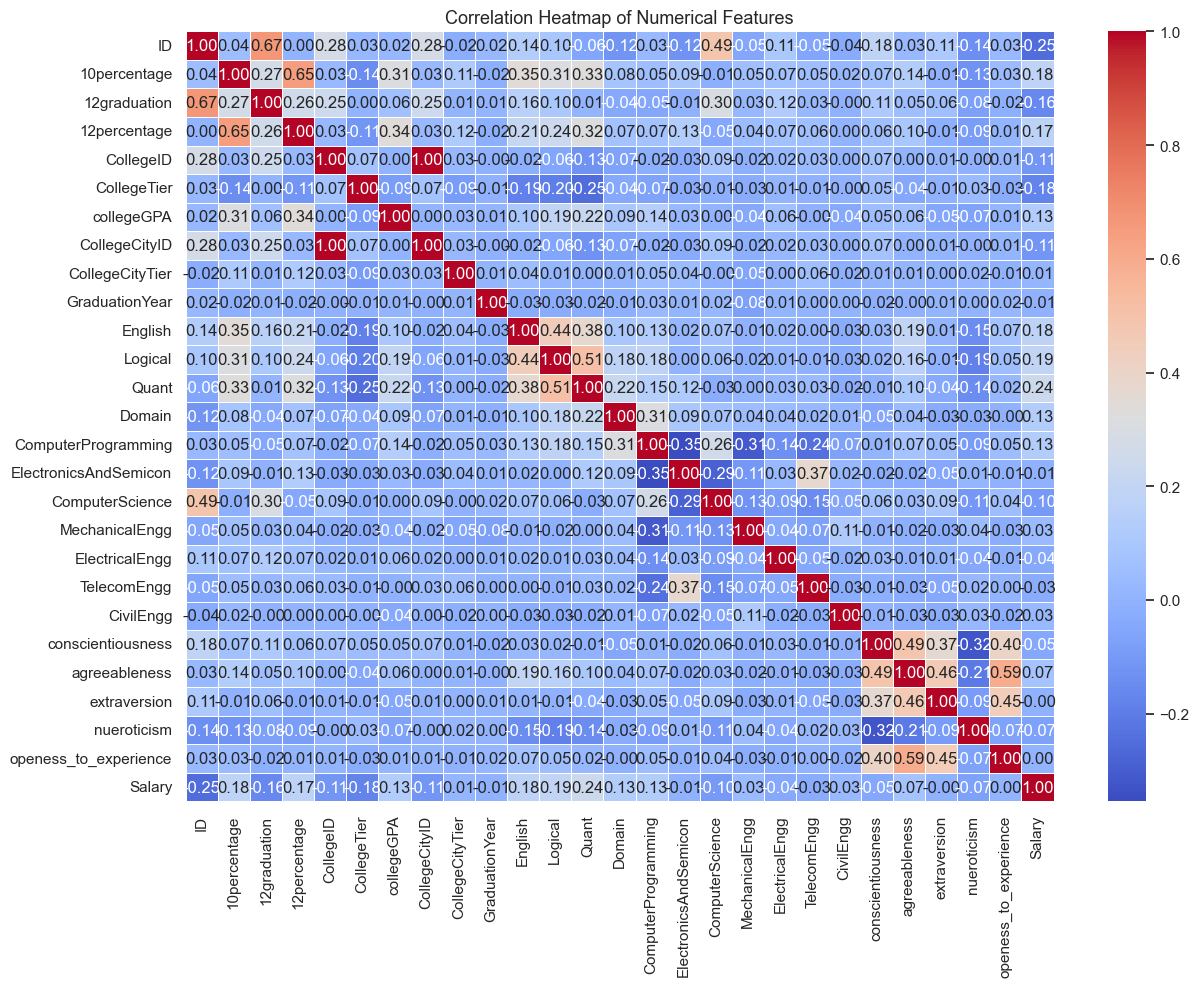

In [14]:
# Full numeric correlation
corr_full = df.corr(numeric_only=True)
plt.figure(figsize=(14, 10))
ax = sns.heatmap(corr_full, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
ax.set_title("Correlation Heatmap of Numerical Features")
plt.show()

## Data Cleaning & Feature Prep
We’ll keep this minimal: remove duplicates, parse dates, basic distributions, scale numeric columns, and one-hot encode categoricals.


In [15]:
# Duplicates removal
before = df.shape[0]
df.drop_duplicates(inplace=True)
after = df.shape[0]
print(f"Removed duplicates: {before - after}")

# Templates (printed for reference, not applied)
print("Templates:")
print("- Drop mostly-null columns: df.drop(columns=['col_name'], inplace=True)")
print("- Fill numeric nulls with mean: df['num_col'].fillna(df['num_col'].mean(), inplace=True)")

Removed duplicates: 0
Templates:
- Drop mostly-null columns: df.drop(columns=['col_name'], inplace=True)
- Fill numeric nulls with mean: df['num_col'].fillna(df['num_col'].mean(), inplace=True)


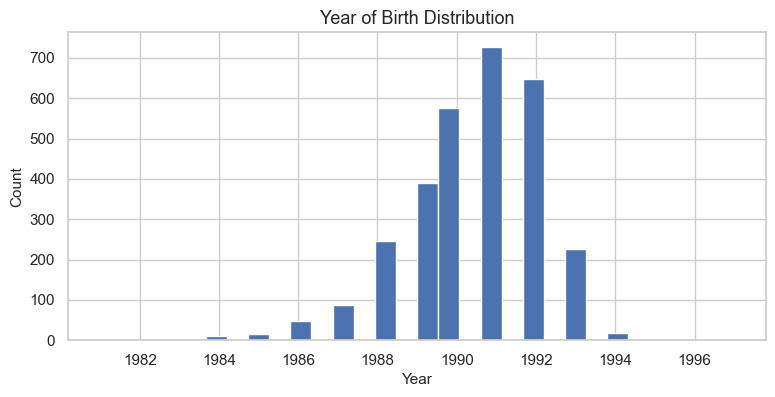

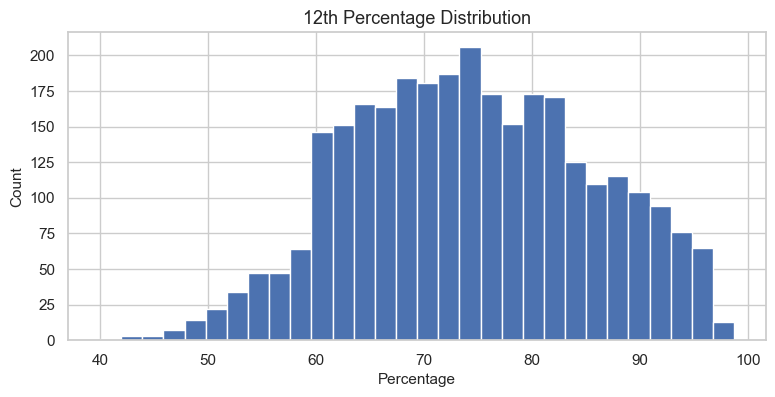

In [16]:
# Parse DOB (if present) and show year distribution
if 'DOB' in df.columns:
    df['DOB'] = pd.to_datetime(df['DOB'], errors='coerce')
    if df['DOB'].notna().any():
        plt.figure(figsize=(9, 4))
        df['DOB'].dt.year.dropna().astype(int).hist(bins=30)
        plt.title("Year of Birth Distribution")
        plt.xlabel("Year"); plt.ylabel("Count")
        plt.show()

# 12th Percentage distribution (sanity check)
if '12percentage' in df.columns:
    ax = df['12percentage'].hist(bins=30)
    plt.title("12th Percentage Distribution")
    plt.xlabel("Percentage"); plt.ylabel("Count")
    plt.show()

In [17]:
# Numeric columns to scale (from your original flow)
numeric_cols = [
    '10percentage', '12percentage', 'collegeGPA', 'English',
    'Logical', 'Quant', 'Domain', 'ComputerProgramming',
    'ElectronicsAndSemicon', 'ComputerScience', 'MechanicalEngg',
    'ElectricalEngg', 'TelecomEngg', 'CivilEngg',
    'conscientiousness', 'agreeableness', 'extraversion',
    'nueroticism', 'openess_to_experience'
]

# Only scale those that exist in the dataset
numeric_cols_present = [c for c in numeric_cols if c in df.columns]

scaler = MinMaxScaler()
df.loc[:, numeric_cols_present] = scaler.fit_transform(df[numeric_cols_present])
print("Scaled numeric columns:", numeric_cols_present)

Scaled numeric columns: ['10percentage', '12percentage', 'collegeGPA', 'English', 'Logical', 'Quant', 'Domain', 'ComputerProgramming', 'ElectronicsAndSemicon', 'ComputerScience', 'MechanicalEngg', 'ElectricalEngg', 'TelecomEngg', 'CivilEngg', 'conscientiousness', 'agreeableness', 'extraversion', 'nueroticism', 'openess_to_experience']


/var/folders/tk/2jxvklsx3pv5sgh5rjj6x7zm0000gn/T/ipykernel_36789/2258071208.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.67625899 0.37410072 0.43884892 ... 0.29496403 0.41007194 0.27338129]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[:, numeric_cols_present] = scaler.fit_transform(df[numeric_cols_present])
/var/folders/tk/2jxvklsx3pv5sgh5rjj6x7zm0000gn/T/ipykernel_36789/2258071208.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.78333333 0.4        0.46666667 ... 0.38333333 0.75       0.325     ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[:, numeric_cols_present] = scaler.fit_transform(df[numeric_cols_present])
/var/folders/tk/2jxvklsx3pv5sgh5rjj6x7zm0000gn/T/ipykernel_36789/2258071208.py:15: FutureWarning: Setting an ite

In [18]:
# Categorical columns (from your original flow)
categorical_cols = ['Gender', '10board', '12board', 'Degree', 'Specialization', 'CollegeState']
categorical_cols_present = [c for c in categorical_cols if c in df.columns]

df_encoded = pd.get_dummies(df, columns=categorical_cols_present, drop_first=True)
print("Encoded categoricals:", categorical_cols_present)
print("Encoded shape:", df_encoded.shape)

Encoded categoricals: ['Gender', '10board', '12board', 'Degree', 'Specialization', 'CollegeState']
Encoded shape: (2998, 594)


## Modeling
We split data, train a baseline Linear Regression, then compare with top-feature selection and tuned Ridge/Lasso.


In [19]:
# Features/target
target_col = 'Salary'
drop_if_present = ['ID', 'DOB']  # safely drop if they exist
drop_cols = [c for c in drop_if_present if c in df_encoded.columns]

X = df_encoded.drop(columns=[target_col] + drop_cols, errors='ignore')
y = df_encoded[target_col]

# 80/20: train+val / test
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

# From trainval: 60/20: train / val  (so total: 60/20/20)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.25, random_state=42
)

print("Shapes →",
      "X_train:", X_train.shape, "| X_val:", X_val.shape, "| X_test:", X_test.shape)

Shapes → X_train: (1798, 591) | X_val: (600, 591) | X_test: (600, 591)


In [20]:
# Baseline Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)

y_val_pred = lr.predict(X_val)
y_test_pred = lr.predict(X_test)

val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"Linear Regression → Val RMSE: {val_rmse:.2f} | Test RMSE: {test_rmse:.2f}")

Linear Regression → Val RMSE: 248037.29 | Test RMSE: 167076.43


In [21]:
# Compute numeric correlations vs Salary using the pre-scaled original df
corr_series = df.corr(numeric_only=True)[target_col].abs().sort_values(ascending=False)
top_features = [c for c in corr_series.index.tolist() if c != target_col][:8]  # top 8 (excluding target)
print("Selected Top Features:", top_features)

# Align with encoded frame (they should be numeric columns present in df_encoded)
top_features_present = [c for c in top_features if c in df_encoded.columns]
X_top = df_encoded[top_features_present]
y_top = df_encoded[target_col]

# Split with same strategy
X_trainval_top, X_test_top, y_trainval_top, y_test_top = train_test_split(
    X_top, y_top, test_size=0.20, random_state=42
)
X_train_top, X_val_top, y_train_top, y_val_top = train_test_split(
    X_trainval_top, y_trainval_top, test_size=0.25, random_state=42
)

# Retrain Linear Regression on top features
lr_top = LinearRegression()
lr_top.fit(X_train_top, y_train_top)

y_val_pred_top = lr_top.predict(X_val_top)
y_test_pred_top = lr_top.predict(X_test_top)

val_rmse_top = np.sqrt(mean_squared_error(y_val_top, y_val_pred_top))
test_rmse_top = np.sqrt(mean_squared_error(y_test_top, y_test_pred_top))

print(f"Linear Regression (Top Features) → Val RMSE: {val_rmse_top:.2f} | Test RMSE: {test_rmse_top:.2f}")

Selected Top Features: ['ID', 'Quant', 'Logical', '10percentage', 'English', 'CollegeTier', '12percentage', '12graduation']
Linear Regression (Top Features) → Val RMSE: 229930.32 | Test RMSE: 155034.23


In [22]:
# Ridge & Lasso on top features with simple alpha grid
param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}

ridge = Ridge()
ridge_cv = GridSearchCV(ridge, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
ridge_cv.fit(X_train_top, y_train_top)

lasso = Lasso(max_iter=10000)
lasso_cv = GridSearchCV(lasso, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
lasso_cv.fit(X_train_top, y_train_top)

# Validation performance
ridge_val_rmse = np.sqrt(mean_squared_error(y_val_top, ridge_cv.predict(X_val_top)))
lasso_val_rmse = np.sqrt(mean_squared_error(y_val_top, lasso_cv.predict(X_val_top)))

print("Best Ridge alpha:", ridge_cv.best_params_['alpha'], "| Val RMSE:", round(ridge_val_rmse, 2))
print("Best Lasso alpha:", lasso_cv.best_params_['alpha'], "| Val RMSE:", round(lasso_val_rmse, 2))

Best Ridge alpha: 1 | Val RMSE: 229909.54
Best Lasso alpha: 0.01 | Val RMSE: 229930.32


In [23]:
# Final test evaluation on top features
lr_test_rmse_top = np.sqrt(mean_squared_error(y_test_top, lr_top.predict(X_test_top)))
ridge_test_rmse = np.sqrt(mean_squared_error(y_test_top, ridge_cv.predict(X_test_top)))
lasso_test_rmse = np.sqrt(mean_squared_error(y_test_top, lasso_cv.predict(X_test_top)))

print(f"Linear Regression (Top) → Test RMSE: {lr_test_rmse_top:.2f}")
print(f"Ridge (Top, alpha={ridge_cv.best_params_['alpha']}) → Test RMSE: {ridge_test_rmse:.2f}")
print(f"Lasso (Top, alpha={lasso_cv.best_params_['alpha']}) → Test RMSE: {lasso_test_rmse:.2f}")

Linear Regression (Top) → Test RMSE: 155034.23
Ridge (Top, alpha=1) → Test RMSE: 154949.49
Lasso (Top, alpha=0.01) → Test RMSE: 155034.22


In [24]:
# Evaluation Summary

summary = {
    "Linear Regression (All Features)": {"Val RMSE": float(val_rmse), "Test RMSE": float(test_rmse)},
    "Linear Regression (Top Features)": {"Val RMSE": float(val_rmse_top), "Test RMSE": float(test_rmse_top)},
    f"Ridge (Top, α={ridge_cv.best_params_['alpha']})": {
        "Val RMSE": float(np.sqrt(mean_squared_error(y_val_top, ridge_cv.predict(X_val_top)))),
        "Test RMSE": float(np.sqrt(mean_squared_error(y_test_top, ridge_cv.predict(X_test_top))))
    },
    f"Lasso (Top, α={lasso_cv.best_params_['alpha']})": {
        "Val RMSE": float(np.sqrt(mean_squared_error(y_val_top, lasso_cv.predict(X_val_top)))),
        "Test RMSE": float(np.sqrt(mean_squared_error(y_test_top, lasso_cv.predict(X_test_top))))
    },
}
pd.DataFrame(summary).T

,Val RMSE,Test RMSE
Linear Regression (All Features),248037.289897,167076.425236
Linear Regression (Top Features),229930.322816,155034.226615
"Ridge (Top, α=1)",229909.541950,154949.491267
"Lasso (Top, α=0.01)",229930.320747,155034.216908


### Author
**Rohit Ravula**  
📧 **Email:** [rohitsaikiran.r@gmail.com](mailto:rohitsaikiran.r@gmail.com)  
🐙 **GitHub:** [@Rohit-Sai-Kiran](https://github.com/RohitSaiKiran)
